In [89]:
import numpy as np
import pathlib
from datetime import datetime

# classifiers
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [109]:
def load_data(filename, train=True):
    """
    Function loads data stored in the file filename and returns it as a numpy ndarray.
    
    Inputs:
        filename: given as a string
        (optional) train: used to determine whether this is the training or test set
        
    Outputs:
        Data contained in the file, returned as a numpy ndarray
    """
    X = []
    y = []
    with open(filename) as f:
        for line in f:
            if (train):
                # remove \n, split on space, separate into label and weights
                X.append(line.strip().split(' ')[1:])
                y.append(line.strip().split(' ')[0])
            else:
                X.append(line.strip().split(' '))
                
    # convert to np, cast to int, and remove the headers
    X = np.asarray(X[1:]).astype(int)
    if (train):
        y = np.asarray(y[1:]).astype(int)
        
    return X, y

In [4]:
def split_data(x_train, y_train):
    '''
    Function for cross validiation. 
    
    Inputs: 
        x_train: training data points
        y_train: training labels
        
    Outputs:
        trainX: randomized 4/5 of given data points
        trainY: corresponding labels
        testX: randomized 1/5 of given data points
        testY: corresponding lables
    '''
    dataSplit = ShuffleSplit(n_splits = 1, test_size = 0.2)
    for train, test in dataSplit.split(x_train, y_train):
        return x_train[train], y_train[train], x_train[test], y_train[test] 
       

In [5]:
def normalization(X_train, X_test):
    '''
    Function to normalize training and test data

    Inputs:
        X_train: training set data points
        X_test: test set data points

    Outputs:
        train_norm: normalized training set data points
        test_norm: normalized test set data points
    '''
    normalizer = Normalizer().fit(X_train)
    train_norm = normalizer.transform(X_train)
    test_norm = normalizer.transform(X_test)

    return (train_norm, test_norm)

In [114]:
# load the data
X_train, y_train = load_data("training_data.txt")
X_test, _ = load_data("test_data.txt", False)

# normalize training and test data
X_train_n, X_test_n = normalization(X_train, X_test)    

# split the data in to training and testing so we can test ourselves
trainX, trainY, testX, testY = split_data(X_train_n, y_train)

In [7]:
def make_predictions(clf, X, y, test):
    '''
    Function to train and test our classifier
    
    Inputs:
        clf: classifier
        X: data points
        y: labels
        test: test set
    
    Outputs:
        predictions: predictions from running the clf on the test set
    '''
    clf.fit(X, y)
    predictions = clf.predict(test)
    predictions = predictions.astype(int)
    
    return predictions

In [103]:
def save_data(data, filename="%s.txt" % datetime.today().strftime("%X").replace(":", "")):
    '''
    Function to save the predictions by the classifier
    
    Inputs: predictions, (optional) filename
        If filename isn't specified, then it just uses the current time
    
    Outputs: Does not return anything
        Writes the submisssion to a textfile that should have the same format as the sample_submission.txt
    '''
    
    # Creates a new submissions folder if one doesn't exist
    pathlib.Path('submissions').mkdir(parents=True, exist_ok=True)
    with open("submissions\\%s" % filename, "w") as f:
        f.write("Id,Prediction\n")
        for Id, prediction in enumerate(data, 1):
            string = str(Id) + ',' + str(prediction) + '\n'
            f.write(string)
        

In [9]:
def plot_learning_curve(train_errors, validation_errors, vary_param, param_label):
    '''
    Function to plot learning curve for different degrees of regularization

    Inputs:
        train_errors: array of training errors corresponding to various reg_params
        validation_errors: array of validation erros corresponding to various reg_params
        vary_params: array of various values of the varied parameter
        param_label: string input for regularization parameter being varied, e.g. alpha, learning rate
    '''
    plt.figure()
    plt.plot(vary_param, train_errors, c = 'green', label='Training Error')
    plt.plot(vary_param, validation_errors, c = 'red', label='Validation Error')
    plt.scatter(vary_param, train_errors, c = 'green')
    plt.scatter(vary_param, validation_errors, c = 'red')
    plt.xlabel(param_label)
    plt.ylabel('Error')
    plt.legend()
    plt.show()

In [10]:
def vary_alphas(clf, xTrain, yTrain, xTest, yTest, alphas):
    '''
    Function to compute training and validation errors for varied regularization parameter
    
    Inputs:
        clf: classifier
        xTrain: data to train on
        yTrain: labels to training data
        xTest: data to test on (validation set)
        yTest: labels to validation set
        alphas: array of various values of the regularization parameter
        
    Outputs:
        train_errors: array of training errors corresponding to various reg_params
        validation_errors: array of validation erros corresponding to various reg_params
    '''
    training_errors, val_errors = np.zeros(len(alphas)), np.zeros(len(alphas))
    for i in range(len(alphas)):
        clf.set_params(alpha=alphas[i])

        # train and test our model
        train_predictions = make_predictions(clf, xTrain, yTrain, xTrain)
        val_predictions = make_predictions(clf, xTrain, yTrain, xTest)
        # return accuracy
        training_errors[i] = percentError(train_predictions, yTrain)
        val_errors[i] = percentError(val_predictions, yTest)

    plot_learning_curve(training_errors, val_errors, alphas, 'alpha')
    return(training_errors, val_errors)

In [11]:
def vary_learning_rates(clf, xTrain, yTrain, xTest, yTest, learning_rates):
    '''
    Function to compute training and validation errors for varied regularization parameter
    
    Inputs:
        clf: classifier
        xTrain: data to train on
        yTrain: labels to training data
        xTest: data to test on (validation set)
        yTest: labels to validation set
        learning_rates: array of various learning rate values
        
    Outputs:
        train_errors: array of training errors corresponding to various learning rates
        validation_errors: array of validation erros corresponding to various learning rates
    '''
    training_errors, val_errors = np.zeros(len(learning_rates)), np.zeros(len(learning_rates))
    for i in range(len(learning_rates)):
        clf.set_params(learning_rate=learning_rates[i])

        # train and test our model
        train_predictions = make_predictions(clf, xTrain, yTrain, xTrain)
        val_predictions = make_predictions(clf, xTrain, yTrain, xTest)
        # return accuracy
        training_errors[i] = percentError(train_predictions, yTrain)
        val_errors[i] = percentError(val_predictions, yTest)

    plot_learning_curve(training_errors, val_errors, learning_rates, 'Learning Rate')
    return(training_errors, val_errors)

In [12]:
def ridgeReg(xTrain, yTrain, xTest):
    '''
    Function to perform ridge regression. 
    
    Inputs:
        xTrain: data to train on
        yTrain: labels of the training data
        xTest: data to predict on
        
    Outputs:
        predictions: predicted labels of the data
    '''
    cutoff = 0.5
    
    ridge = Ridge(alpha = 200)
    ridge.fit(xTrain, yTrain)
    predictions = ridge.predict(xTest)
    predictions[predictions > cutoff] = 1
    predictions[predictions < cutoff] = 0
    predictions = predictions.astype(int) # converts the labels to int or else the submission won't work
    
    return predictions

In [49]:
def percentError(yPred, yTrue):
    '''
    Calculates the percent error between two given label sets
    
    Inputs:
        yPred: predicted labels
        yTrue: actual labels
    
    Outputs:
        error: float of the number of mismatches divided by total length
    '''     
    return 1.0-np.sum(np.equal(yPred, yTrue))/len(yTrue)

In [16]:
# testing Gradient Boost    
gbclf = GradientBoostingClassifier()
gb = make_predictions(gbclf, trainX, trainY, testX)
print("Gradient Boost Error:", percentError(gb, testY))

Gradient Boost Error: 0.1985


In [17]:
# testing MLPClassifier, this is bad but I feel like it should be better
mlpclf = MLPClassifier(activation = 'logistic')
mlp = make_predictions(mlpclf, trainX, trainY, testX)
print("MLP Error:", percentError(mlp, testY))

MLP Error: 0.15075000000000005


In [18]:
# submission: logReg
logclf = LogisticRegression()
log = make_predictions(logclf, trainX, trainY, testX)
print("Logistic Error:", percentError(log, testY))

Logistic Error: 0.15200000000000002


In [19]:
# testing PassiveAggresiveClassifier
paclf = PassiveAggressiveClassifier(max_iter=1000)
pa = make_predictions(paclf, trainX, trainY, testX)
print("Passive Aggressive Classifier Error:", percentError(pa, testY))

Passive Aggressive Classifier Error: 0.16700000000000004


Ridge Classifier Error: 0.15100000000000002


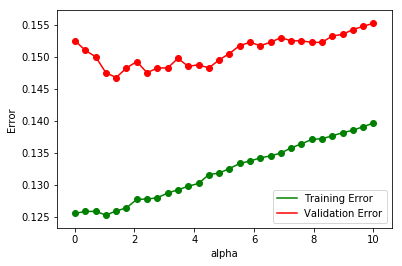

(array([0.1255   , 0.1258125, 0.1258125, 0.12525  , 0.125875 , 0.126375 ,
        0.1276875, 0.12775  , 0.1279375, 0.1286875, 0.1291875, 0.12975  ,
        0.1301875, 0.1315625, 0.1318125, 0.1325   , 0.1333125, 0.1336875,
        0.1341875, 0.1345   , 0.1349375, 0.13575  , 0.136375 , 0.1370625,
        0.1371875, 0.137625 , 0.138125 , 0.1385   , 0.1390625, 0.139625 ]),
 array([0.1525 , 0.151  , 0.15   , 0.1475 , 0.14675, 0.14825, 0.14925,
        0.1475 , 0.14825, 0.14825, 0.14975, 0.1485 , 0.14875, 0.14825,
        0.1495 , 0.1505 , 0.15175, 0.15225, 0.15175, 0.15225, 0.153  ,
        0.1525 , 0.1525 , 0.15225, 0.15225, 0.15325, 0.1535 , 0.15425,
        0.15475, 0.15525]))

In [20]:
# testing and plotting RidgeClassifier for various alphas
alphas = np.linspace(0.01, 10, 30)
ridgeclf = RidgeClassifier(alpha=0.35448276)
ridge = make_predictions(ridgeclf, trainX, trainY, testX)
print("Ridge Classifier Error:", percentError(ridge, testY))
vary_alphas(ridgeclf, trainX, trainY, testX, testY, alphas)

Adaboost Classifier Error: 0.1985


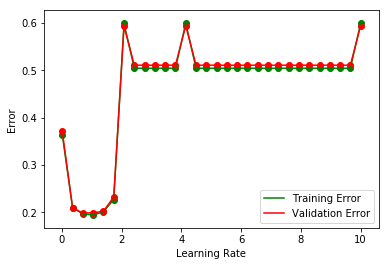

(array([0.363875 , 0.209875 , 0.1963125, 0.1941875, 0.2010625, 0.226875 ,
        0.5985625, 0.5040625, 0.5040625, 0.5040625, 0.5040625, 0.5040625,
        0.59925  , 0.5040625, 0.5040625, 0.5040625, 0.5040625, 0.5040625,
        0.5040625, 0.5040625, 0.5040625, 0.5040625, 0.5040625, 0.5040625,
        0.5040625, 0.5040625, 0.5040625, 0.5040625, 0.5040625, 0.59925  ]),
 array([0.3705 , 0.20925, 0.19825, 0.199  , 0.202  , 0.23225, 0.593  ,
        0.5105 , 0.5105 , 0.5105 , 0.5105 , 0.5105 , 0.594  , 0.5105 ,
        0.5105 , 0.5105 , 0.5105 , 0.5105 , 0.5105 , 0.5105 , 0.5105 ,
        0.5105 , 0.5105 , 0.5105 , 0.5105 , 0.5105 , 0.5105 , 0.5105 ,
        0.5105 , 0.594  ]))

In [21]:
# testing and plotting AdaBoostClassifier for various steps
steps = np.linspace(0.01, 10, 30)
abclf = AdaBoostClassifier()
ab = make_predictions(abclf, trainX, trainY, testX)
print("Adaboost Classifier Error:", percentError(ab, testY))
vary_learning_rates(abclf, trainX, trainY, testX, testY, steps)

In [22]:
rfclf = RandomForestClassifier()
rf = make_predictions(rfclf, trainX, trainY, testX)
print("Random Forest Error:", percentError(rf, testY))

Random Forest Error: 0.21399999999999997


In [24]:
knclf = KNeighborsClassifier()
kn = make_predictions(knclf, trainX, trainY, testX)
print("KNN Error:", percentError(kn, testY))

KNN Error: 0.32825000000000004


In [25]:
gnbclf = GaussianNB()
gnb = make_predictions(gnbclf, trainX, trainY, testX)
print("GaussianNB Error:", percentError(gnb, testY))

GaussianNB Error: 0.21725000000000005


In [26]:
dtclf = DecisionTreeClassifier()
dt = make_predictions(dtclf, trainX, trainY, testX)
print("Decision Tree Error:", percentError(dt, testY))

Decision Tree Error: 0.2865


In [116]:
etclf = ExtraTreesClassifier(350)
et = make_predictions(etclf, trainX, trainY, testX)
print("Extra Trees Error:", percentError(et, testY))
# Extra Trees Error: 0.15874999999999995 for 200
# 0.14500000000000002 for 300
# 0.15300000000000002 for 350
# 0.14849999999999997 for 400
# 0.14575000000000005 for 500
# 0.14400000000000002 for 1000
# Extra Trees Error: 0.15600000000000003 for 300 with unnormalized data

Extra Trees Error: 0.15300000000000002


In [113]:
# etclf = ExtraTreesClassifier(1000)
# # et = make_predictions(etclf, trainX, trainY, testX)
# # print("Extra Trees Error:", percentError(et, testY))
# et = make_predictions(etclf, X_train_n, y_train, X_test_n)
# save_data(et)

In [87]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras import regularizers

from keras.utils import to_categorical
y_binary = to_categorical(y_train)

rate = 0.0
model = Sequential()
model.add(Dense(100, input_shape=(1000,)))
model.add(Activation('relu'))
model.add(Dropout(rate))

# output layer
model.add(Dense(2))
model.add(Activation('softmax'))

## Printing a summary of the layers and weights in your model
model.summary()

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

fit = model.fit(X_train, y_binary, batch_size=32, epochs=10,
    verbose=1)

testY_binary = to_categorical(testY)

## Printing the accuracy of our model, according to the loss function specified in model.compile above
score = model.evaluate(testX, testY_binary, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 100)               100100    
_________________________________________________________________
activation_68 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 2)                 202       
_________________________________________________________________
activation_69 (Activation)   (None, 2)                 0         
Total params: 100,302
Trainable params: 100,302
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
20000/20000 [==============================] - 6s 315us/step - loss: 0.3994 - acc: 0.8292
Epoch 2/10
20000/20000 [===========

In [86]:
seq_binarypredictions = model.predict(X_test)
seq_predictions = []
for i in seq_binarypredictions:
    if i[0] > i[1]:
        seq_predictions.append(0)
    elif i[0] < i[1]:
        seq_predictions.append(1)
    else:
        print(i[0], i[1], "are equal")
save_data(seq_predictions)

In [ ]:
# acc: 0.9944
# Test score: 0.7648572138100862
# Test accuracy: 0.84225
    
# acc: 0.9934
# Test score: 0.8508109339475631
# Test accuracy: 0.83675

# acc: 0.9999
# Test score: 1.0047595951855182
# Test accuracy: 0.844
    
# acc: 0.9997
# Test score: 0.9556885951161385
# Test accuracy: 0.84225
    
# acc: 0.9249
# Test score: 0.3752474172115326
# Test accuracy: 0.84875
    
# acc: 0.9849
# Test score: 0.43019275814294816
# Test accuracy: 0.8465
    
# acc: 0.9836
# Test score: 0.41660338413715364
# Test accuracy: 0.8445

In [14]:
# save to a file
#     save_data(predictions)

In [ ]:
if __name__ == "__main__":    
    main()

In [ ]:
'''
Tested clfs:
clf = SGDClassifier(loss="log", penalty="l2")
Score: 0.82240

clf = RandomForestClassifier(n_estimators=5000, criterion = 'gini')
Score: 0.82860

model = Sequential()
Score: 0.83980

clf = LogisticRegression()
Score: 0.85019

'''